In [186]:
################################# Load FaceNet model implemented by Hiroki Taniai ############################
################################# https://github.com/nyoki-mtl #################################
from keras.models import load_model
import time

# Start time stamp
t = time.time()

model = load_model('facenet_keras.h5')

# End time stamp
elapsed = time.time() - t
print(elapsed) 

55.77112054824829


C:\Users\57luu\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [1]:
############################ Create a catalogue of images ############################
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
from collections import defaultdict
from itertools import compress
import time

# Start time stamp
t = time.time()

# Get the list of image names in the folder
image_folder =  os.path.join(os.getcwd(), "Images")
list_all = os.listdir(image_folder)
is_file = [os.path.isfile(os.path.join(image_folder, list_name)) for list_name in list_all]
file_list = list(compress(list_all, is_file))

# Parse and create catalogue
max_list_length = 0;
file_name_parsed = []
image_catalogue = {}
for file_name in file_list:
    file_name = file_name[:-4]
    file_name_parsed_old = file_name_parsed
    file_name_parsed = file_name.split('_')
    if file_name_parsed[0] not in image_catalogue.keys():
        image_catalogue[file_name_parsed[0]] = {'mix_low': [], 'mix_high': []}
        if len(image_catalogue.keys()) > 1:
            max_list_length = max(max_list_length, len(image_catalogue[file_name_parsed_old[0]]['mix_low']), 
                                  len(image_catalogue[file_name_parsed_old[0]]['mix_high']))        
    else:    
        if file_name_parsed[1] == 'range(8, 18)':
            current_list = image_catalogue[file_name_parsed[0]]['mix_low']
            if  len(current_list)==0:
                current_list = [file_name_parsed[2]]
            else:
                current_list.append(file_name_parsed[2])
            image_catalogue[file_name_parsed[0]]['mix_low'] = current_list
        elif file_name_parsed[1] == 'range(2, 4)':
            current_list = image_catalogue[file_name_parsed[0]]['mix_high']
            if  len(current_list)==0:
                current_list = [file_name_parsed[2]]
            else:
                current_list.append(file_name_parsed[2])
            image_catalogue[file_name_parsed[0]]['mix_high'] = current_list

# End time stamp
elapsed = time.time() - t
print(elapsed)      


0.11120986938476562


In [189]:
####################### Load, preprocess and compute embedding of the images #######################
from PIL import Image
t = time.time()

# Preprocess to meet the model input (standardized across channel and 4D - first one is face number)
def preprocessing(x):
    # resize the image
    x = x.resize((160, 160), resample=Image.BILINEAR)
    
    # scale pixel values    
    x = np.array(x).astype('float32')
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')
        
    # standardize pixel values across channels (global)
    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    
    # expand dimension if dimension < 4
    if x.ndim == 3:
        y = np.expand_dims(y, axis=0)
    return y

def load_image(file_path):
    image = preprocessing(Image.open(file_path))
    
    return image
    
# List of original seeds
seed_original = image_catalogue.keys()

# Numpy arrays of embeddings
embed_vector_size = 128
embed_original = np.empty((len(seed_original), embed_vector_size))
embed_original.fill(np.nan)

embed_mix_low = np.empty((len(seed_original), max_list_length, embed_vector_size))
embed_mix_low.fill(np.nan)

embed_mix_high = np.empty((len(seed_original), max_list_length, embed_vector_size))
embed_mix_high.fill(np.nan)

# Read in images and compute embedding
index_seed = 0;
for original_seed, mix_seed_both in image_catalogue.items():
    # Original image
    file_path = os.path.join(image_folder, ''.join([original_seed, "_original.png"]))
    embed_original[index_seed] = model.predict(load_image(file_path))
    for mix_type, mix_seed_list in mix_seed_both.items():
        for index_list, mix_seed in enumerate(mix_seed_list):
            # Mix image
            if mix_type == 'mix_low':
                file_path = os.path.join(image_folder, ''.join([original_seed, "_range(8, 18)_", mix_seed, ".png"]))
                embed_mix_low[index_seed, index_list] = model.predict(load_image(file_path))
            elif mix_type == 'mix_high':
                file_path = os.path.join(image_folder, ''.join([original_seed, "_range(2, 4)_", mix_seed, ".png"]))
                embed_mix_high[index_seed, index_list] = model.predict(load_image(file_path))
                
    index_seed = index_seed + 1

# L2 normalize the embedding vectors
epsilon = 1e-20
embed_original = embed_original / np.sqrt(np.maximum(np.sum(np.square(embed_original), axis=-1, keepdims=True), epsilon))
embed_mix_low = embed_mix_low / np.sqrt(np.maximum(np.sum(np.square(embed_mix_low), axis=-1, keepdims=True), epsilon))
embed_mix_high = embed_mix_high / np.sqrt(np.maximum(np.sum(np.square(embed_mix_high), axis=-1, keepdims=True), epsilon))

elapsed = time.time() - t
print(elapsed)   

379.45806884765625


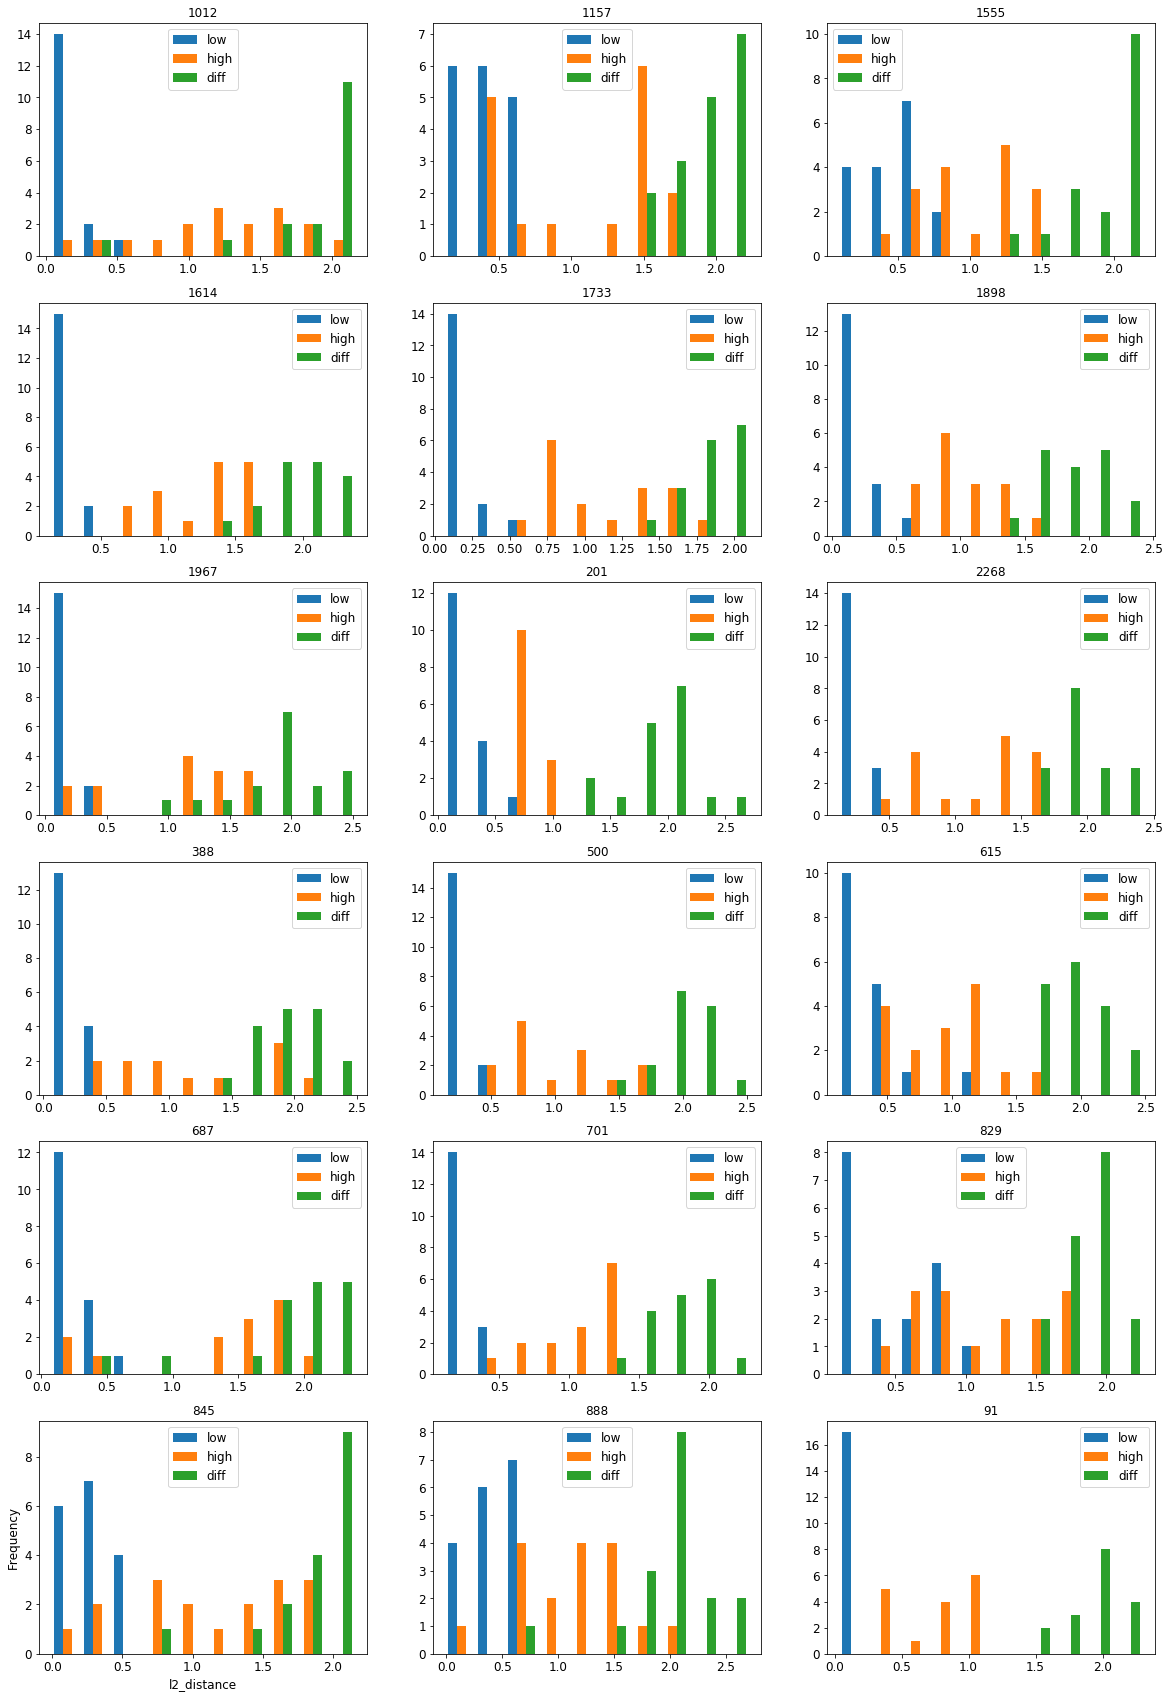

In [190]:
####################### Compute and plot the distance between mixed and original images #######################
# Compute the l2 distance
l2_distance_low = embed_mix_low - np.expand_dims(embed_original, axis=1)
l2_distance_low = np.sum(l2_distance_low ** 2, axis=-1)

l2_distance_high = embed_mix_high - np.expand_dims(embed_original, axis=1)
l2_distance_high = np.sum(l2_distance_high ** 2, axis=-1)

l2_distance_original = np.empty((len(seed_original), len(seed_original)-1))
l2_distance_original.fill(np.nan)
for index in range(len(seed_original)):
    l2_distance = embed_original[index, :] - np.delete(embed_original, obj=index, axis=0)
    l2_distance_original[index, :] = np.sum(l2_distance ** 2, axis=-1)

# Plot histogram
font_size = 12
fig = plt.figure(figsize=(20, 30))
for index, seed in enumerate(seed_original):
    distance_low = l2_distance_low[index]
    distance_low = distance_low[~np.isnan(distance_low)]
    mean_l2_distance_low = np.mean(distance_low)
    std_l2_distance_low = np.std(distance_low)
    
    distance_high = l2_distance_high[index]
    distance_high = distance_high[~np.isnan(distance_high)]
    mean_l2_distance_high = np.mean(distance_high)
    std_l2_distance_high = np.std(distance_high) 

    distance_original = l2_distance_original[index]
    distance_original = distance_original[~np.isnan(distance_original)]
    mean_l2_distance_high = np.mean(distance_original)
    std_l2_distance_high = np.std(distance_original) 
    
    ax = fig.add_subplot(6, 3, index+1)
    n = plt.hist([distance_low, distance_high, distance_original], bins=10, rwidth=0.9, label = ['low', 'high', 'diff'])
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.set_title(seed)
    if index == 15:
        ax.set_ylabel('Frequency', fontsize = font_size)
        ax.set_xlabel('l2_distance', fontsize = font_size)
#     ax.set_title(''.join(["Low (", np.array2string(mean_l2_distance_low, precision=2), ", ", np.array2string(std_l2_distance_low, precision=2), ")" 
#                            "; High (", np.array2string(mean_l2_distance_high, precision=2), ", ", np.array2string(std_l2_distance_high, precision=2), ")"]), fontsize = font_size)
    ax.legend(fontsize = font_size)
    
plt.savefig('hist_embed_128.pdf', bbox_inches='tight')        

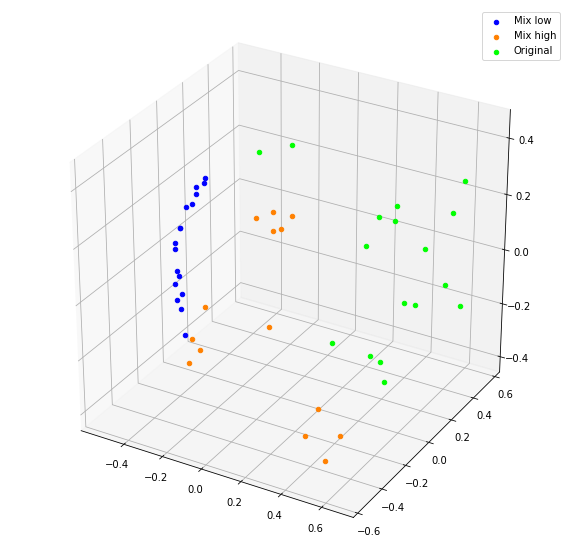

In [285]:
############################ Explore the embedding space with PCA ############################
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Prepare the embed array for PCA
index_image_test = list(seed_original).index('1967')

embed_mix_low_test = np.squeeze(embed_mix_low[index_image_test, :, :])
index_delete = np.where(np.isnan(embed_mix_low_test[:, 0]))
embed_mix_low_test = np.delete(embed_mix_low_test, obj=index_delete, axis=0)

embed_mix_high_test = np.squeeze(embed_mix_high[index_image_test, :, :])
index_delete = np.where(np.isnan(embed_mix_high_test[:, 0]))
embed_mix_high_test = np.delete(embed_mix_high_test, obj=index_delete, axis=0)

embed_original_test = np.delete(embed_original, obj=index_image_test, axis=0)

embed_array_test = np.concatenate((embed_mix_low_test, embed_mix_high_test, embed_original_test), axis=0)
embed_label = np.concatenate((np.zeros(embed_mix_low_test.shape[0]), np.ones(embed_mix_high_test.shape[0]),
                             2*np.ones(embed_original_test.shape[0])), axis=0)

# Perform PCA with 3 components
pca = PCA(n_components=3)
embed_transform = pca.fit_transform(embed_array_test)
embed_transform_low = embed_transform[embed_label==0]
embed_transform_high = embed_transform[embed_label==1]
embed_transform_original = embed_transform[embed_label==2]

# Plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
color_map = np.zeros((3, 3))
color_map[0,:] = np.array([0, 0, 1])
color_map[1,:] = np.array([1, 0.5, 0])
color_map[2,:] = np.array([0, 1, 0])
ax.scatter(xs=embed_transform_low[:, 0], ys=embed_transform_low[:, 1], zs=embed_transform_low[:, 2],
           depthshade=False, c=np.expand_dims(color_map[0], axis=0), label='Mix low')
ax.scatter(xs=embed_transform_high[:, 0], ys=embed_transform_high[:, 1], zs=embed_transform_high[:, 2],
           depthshade=False, c=np.expand_dims(color_map[1], axis=0), label='Mix high')
ax.scatter(xs=embed_transform_original[:, 0], ys=embed_transform_original[:, 1], zs=embed_transform_original[:, 2],
           depthshade=False, c=np.expand_dims(color_map[2], axis=0), label='Original')
ax.legend()

In [287]:
# Plot cumulative variance explained
pca = PCA()
embed_transform = pca.fit_transform(embed_array_test)
cum_sum = np.cumsum(pca.explained_variance_ratio_)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
plt.plot(cum_sum)
ax.set_xlabel('# PCA components')
ax.set_ylabel('Fraction cumulative variance explained')

(48, 16)

In [163]:
################################# Load FaceNet model implemented by David Sandberg ############################
################################# https://github.com/davidsandberg/facenet #################################
import re

class FaceNet():
    def __init__(self):
        tf.logging.set_verbosity(tf.logging.ERROR)
        self.sess = tf.Session().__enter__()
        self.load_model(os.path.join("facenet", "pretrained"))
        self.images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        self.embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        self.phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        self.embedding_size = self.embeddings.get_shape()[1]
        self.emb_array = np.zeros((1, self.embedding_size))

    def __del__(self):
        self.sess.close()

    def compute_embeddings(self, path):
        image = self.load_image(path)
        self.feed_dict = { self.images_placeholder:image, self.phase_train_placeholder:False }
        self.emb_array[0,:] = self.sess.run(self.embeddings, feed_dict=self.feed_dict)
        return self.emb_array[0,:]

    def prewhiten(self, x):
        # resize the image
        x = x.resize((160, 160), resample=Image.BILINEAR)

        # scale pixel values    
        x = np.array(x).astype('float32')
        if x.ndim == 4:
            axis = (1, 2, 3)
            size = x[0].size
        elif x.ndim == 3:
            axis = (0, 1, 2)
            size = x.size
        else:
            raise ValueError('Dimension should be 3 or 4')

        # standardize pixel values across channels (global)
        mean = np.mean(x, axis=axis, keepdims=True)
        std = np.std(x, axis=axis, keepdims=True)
        std_adj = np.maximum(std, 1.0/np.sqrt(size))
        y = (x - mean) / std_adj
        
        return y  
    
    def load_image(self, image_path):
        image = np.zeros((1, 160, 160, 3))
        img = Image.open(image_path)
        img = self.prewhiten(img)
        image[0,:,:,:] = img
        return image

    def load_model(self, model=os.path.join("facenet", "pretrained")):
        model_exp = os.path.expanduser(model)
        print('Model directory: %s' % model_exp)
        meta_file, ckpt_file = self.get_model_filenames(model_exp)
        
        print('Metagraph file: %s' % meta_file)
        print('Checkpoint file: %s' % ckpt_file)
      
        self.saver = tf.train.import_meta_graph(os.path.join(model_exp, meta_file), input_map=None)
        self.saver.restore(tf.get_default_session(), os.path.join(model_exp, ckpt_file))

    def get_model_filenames(self, model_dir):
        files = os.listdir(model_dir)
        meta_files = [s for s in files if s.endswith('.meta')]
        if len(meta_files)==0:
            raise ValueError('No meta file found in the model directory (%s)' % model_dir)
        elif len(meta_files)>1:
            raise ValueError('There should not be more than one meta file in the model directory (%s)' % model_dir)
        meta_file = meta_files[0]
        ckpt = tf.train.get_checkpoint_state(model_dir)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_file = os.path.basename(ckpt.model_checkpoint_path)
            return meta_file, ckpt_file

        meta_files = [s for s in files if '.ckpt' in s]
        max_step = -1
        for f in files:
            step_str = re.match(r'(^model-[\w\- ]+.ckpt-(\d+))', f)
            if step_str is not None and len(step_str.groups())>=2:
                step = int(step_str.groups()[1])
                if step > max_step:
                    max_step = step
                    ckpt_file = step_str.groups()[0]
        return meta_file, ckpt_file
    
    def get_layer_name_and_weights(self, model_filepath=os.path.join("facenet", "pretrained", "20180402-114759.pb")):
        self.graph = tf.Graph()

        with tf.gfile.GFile(model_filepath, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())

        print('Check out the input placeholders:')
        nodes = [n.name + ' => ' +  n.op for n in graph_def.node if n.op in ('Placeholder')]
        for node in nodes:
            print(node)

        with self.graph.as_default():
        	# Define input tensor
        	self.input = tf.placeholder(np.float32, shape = [None, 160, 160, 3], name='input')
        	self.dropout_rate = tf.placeholder(tf.float32, shape = [])
        	tf.import_graph_def(graph_def, {'input': self.input})

        self.graph.finalize()

        print('Model loading complete!')

        # Get layer names
        layers = [op.name for op in self.graph.get_operations()]
        for layer in layers:
            print(layer)
        
        # Check out the weights of the nodes
        weight_nodes = [n for n in graph_def.node if n.op == 'Const']
        
        return layer, weight_nodes

# Load the model
model = FaceNet()    

In [176]:
####################### Load, preprocess and compute embedding of the images #######################
from PIL import Image
t = time.time()

# List of original seeds
seed_original = image_catalogue.keys()

# Numpy arrays of embeddings
embed_vector_size = 512
embed_original = np.empty((len(seed_original), embed_vector_size))
embed_original.fill(np.nan)

embed_mix_low = np.empty((len(seed_original), max_list_length, embed_vector_size))
embed_mix_low.fill(np.nan)

embed_mix_high = np.empty((len(seed_original), max_list_length, embed_vector_size))
embed_mix_high.fill(np.nan)

# Read in images and compute embedding
index_seed = 0;
for original_seed, mix_seed_both in image_catalogue.items():
    # Original image
    file_path = os.path.join(image_folder, ''.join([original_seed, "_original.png"]))
    embed_original[index_seed] = model.compute_embeddings(file_path)
    for mix_type, mix_seed_list in mix_seed_both.items():
        for index_list, mix_seed in enumerate(mix_seed_list):
            # Mix image
            if mix_type == 'mix_low':
                file_path = os.path.join(image_folder, ''.join([original_seed, "_range(8, 18)_", mix_seed, ".png"]))
                embed_mix_low[index_seed, index_list] = model.compute_embeddings(file_path)
            elif mix_type == 'mix_high':
                file_path = os.path.join(image_folder, ''.join([original_seed, "_range(2, 4)_", mix_seed, ".png"]))
                embed_mix_high[index_seed, index_list] = model.compute_embeddings(file_path)
                
    index_seed = index_seed + 1

elapsed = time.time() - t
print(elapsed)   

217.03902220726013


In [ ]:
####################### Compute and plot the distance between mixed and original images #######################
# Compute the l2 distance
l2_distance_low = embed_mix_low - np.expand_dims(embed_original, axis=1)
l2_distance_low = np.sum(l2_distance_low ** 2, axis=-1)

l2_distance_high = embed_mix_high - np.expand_dims(embed_original, axis=1)
l2_distance_high = np.sum(l2_distance_high ** 2, axis=-1)

l2_distance_original = np.empty((len(seed_original), len(seed_original)-1))
l2_distance_original.fill(np.nan)
for index in range(len(seed_original)):
    l2_distance = embed_original[index, :] - np.delete(embed_original, obj=index, axis=0)
    l2_distance_original[index, :] = np.sum(l2_distance ** 2, axis=-1)

# Plot histogram
font_size = 12
fig = plt.figure(figsize=(20, 30))
for index, seed in enumerate(seed_original):
    distance_low = l2_distance_low[index]
    distance_low = distance_low[~np.isnan(distance_low)]
    mean_l2_distance_low = np.mean(distance_low)
    std_l2_distance_low = np.std(distance_low)
    
    distance_high = l2_distance_high[index]
    distance_high = distance_high[~np.isnan(distance_high)]
    mean_l2_distance_high = np.mean(distance_high)
    std_l2_distance_high = np.std(distance_high) 

    distance_original = l2_distance_original[index]
    distance_original = distance_original[~np.isnan(distance_original)]
    mean_l2_distance_high = np.mean(distance_original)
    std_l2_distance_high = np.std(distance_original) 
    
    ax = fig.add_subplot(6, 3, index+1)
    n = plt.hist([distance_low, distance_high, distance_original], bins=10, rwidth=0.9, label = ['low', 'high', 'diff'])
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.set_title(seed)
    if index == 15:
        ax.set_ylabel('Frequency', fontsize = font_size)
        ax.set_xlabel('l2_distance', fontsize = font_size)
#     ax.set_title(''.join(["Low (", np.array2string(mean_l2_distance_low, precision=2), ", ", np.array2string(std_l2_distance_low, precision=2), ")" 
#                            "; High (", np.array2string(mean_l2_distance_high, precision=2), ", ", np.array2string(std_l2_distance_high, precision=2), ")"]), fontsize = font_size)
    ax.legend(fontsize = font_size)
    
plt.savefig('hist_embed_512.pdf', bbox_inches='tight')    

In [191]:
############################ Save variables ############################
variable_folder =  os.path.join(os.getcwd(), "Variables")
if os.path.isdir(variable_folder)==False:
    os.mkdir(variable_folder)

save_path = os.path.join(variable_folder, "variable_embed_128")
np.savez(save_path, embed_original, embed_mix_low, embed_mix_high)